# Testing Original Code 

Found some discrepancies in code and paper description, so here we will be using a varied version of their main.py to print and keep track of exactly how data is used

In [36]:
import os
import torch
import yaml
import re
from tqdm import tqdm
from datasets import get_dataloaders
from eval import eval_model
from methods import get_model
from models import get_net_optimizer_scheduler
from utils.density import GaussianDensityTorch
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


def show_single_image_pair(image_tensor):
    """
    Display a single image or image pair in detail
    Args:
        image_tensor: Single tensor or list of tensors containing the images
    """
    plt.figure(figsize=(10, 5))

    if isinstance(image_tensor, list):
        # Display original
        plt.subplot(1, 2, 1)
        img = image_tensor[0].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Display augmented
        plt.subplot(1, 2, 2)
        aug_img = image_tensor[1].permute(1, 2, 0).cpu().numpy()
        plt.imshow(aug_img)
        plt.title('Augmented Image')
        plt.axis('off')
    else:
        plt.imshow(image_tensor.permute(1, 2, 0).cpu().numpy())
        plt.title('Image')
        plt.axis('off')

    plt.show()


def get_inputs_labels(data):
    """Processes input data to handle both single-task and multi-task scenarios

    This function is crucial for handling data augmentation and task transitions:
    - For single task data (normal samples): assigns label 0
    - For multi-task data (augmented/multiple categories): assigns sequential labels

    Args:
        data: Either a single tensor or list of tensors
            - Single tensor: normal samples from current task
            - List of tensors: samples from multiple tasks/augmentations

    Returns:
        tuple: (processed inputs, corresponding labels)
    """
    if isinstance(data, list):
        # Multi-task scenario: each element represents different task/augmentation
        inputs = [x.to(args.device) for x in data]
        # Creates sequential labels (0,1,2...) for each task
        labels = torch.arange(len(inputs), device=args.device)
        labels = labels.repeat_interleave(inputs[0].size(0))
        inputs = torch.cat(inputs, dim=0)
    else:
        # Single task scenario: all data from same task (normal samples)
        inputs = data.to(args.device)
        # All normal samples get label 0
        labels = torch.zeros(inputs.size(0), device=args.device).long()
    return inputs, labels


class Namespace(object):
    def __init__(self, somedict):
        for key, value in somedict.items():
            # Verify key is valid Python identifier
            assert isinstance(key, str) and re.match("[A-Za-z_-]", key)

            # Recursively create nested Namespace objects for nested dicts
            if isinstance(value, dict):
                self.__dict__[key] = Namespace(value)
            else:
                self.__dict__[key] = value

    def __getattr__(self, attribute):
        raise AttributeError(
            f"Can not find {attribute} in namespace. Please write {attribute} in your config file(xxx.yaml)!")


def get_args():
    """
    Alternative get_args() function used to get arguments for testing in Jupyter, but should work the same in main.py
    Returns:
    """
    # Read YAML file
    with open('./configs/cad.yaml', 'r') as f:
        config = yaml.safe_load(f)

    # Convert to Namespace object
    args = Namespace(config)
    args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    args.data_dir = "../mvtec_anomaly_detection"
    args.mtd_dir = "../datasets/mtd_ano_mask"
    args.save_checkpoint = True
    args.save_path = "./checkpoints"
    args.noise_ratio = 0
    args.seed = 42

    return args

In [20]:
"""Main training loop implementing the CAD framework

This is taken from main.py exactly, with only removals being for different methods (like other AD/CL methods)
"""
# Set environment params, and implemented a different get_args() to
# work in Jupyter
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
args = get_args()
print(args)

# Initialize model components
net, optimizer, scheduler = get_net_optimizer_scheduler(args)
density = GaussianDensityTorch()  # Used for anomaly score calculation
net.to(args.device)

# Get specific model implementation based on method argument
model = get_model(args, net, optimizer, scheduler)

# Initialize storage for tracking tasks and distributions
dataloaders_train = []  # Stores training dataloaders for all tasks
dataloaders_test = []  # Stores test dataloaders for all tasks
learned_tasks = []  # Keeps track of completed tasks
all_test_filenames = []  # Stores filenames for testing

# Statistics storage for calculating final distribution
task_wise_mean = []  # Stores mean embeddings per task
task_wise_cov = []  # Stores covariance matrices per task
task_wise_train_data_nums = []  # Stores number of samples per task

# Main training loop over tasks
for t in range(args.dataset.n_tasks):
    print('---' * 10, f'Task:{t}', '---' * 10)

    # Get dataloaders for current task and update storage
    # First, passes empty lists
    train_dataloader, dataloaders_train, dataloaders_test, learned_tasks, data_train_nums, all_test_filenames, train_data, test_data = \
        get_dataloaders(args, t, dataloaders_train, dataloaders_test, learned_tasks, all_test_filenames)
    task_wise_train_data_nums.append(data_train_nums)

    # Training loop for current task
    net.train()
    for epoch in tqdm(range(args.train.num_epochs)):
        one_epoch_embeds = []  # Stores embeddings from current epoch

        """
        This 'data' is actually a list of two tensors,
        each of shape 32 x 3 x 224 x 224 (B x C x W X H) for ViT
        get_inputs_labels always makes the first tensor normal (label = 0)
        and the second tensor anomalous (label = 1)
        """
        for batch_idx, (data) in enumerate(train_dataloader):
            inputs, labels = get_inputs_labels(data)
            print(labels)
            break
        break
    break
    # model(epoch, inputs, labels, one_epoch_embeds, t, extra_para=None)

    # # Periodic evaluation during training
    # if args.train.test_epochs > 0 and (epoch + 1) % args.train.test_epochs == 0:
    #     net.eval()
    #     # Update density estimation with current embeddings
    #     density = model.training_epoch(
    #         density,
    #         one_epoch_embeds,
    #         task_wise_mean,
    #         task_wise_cov,
    #         task_wise_train_data_nums,
    #         t
    #     )
    #     # Evaluate model on all learned tasks
    #     eval_model(args, epoch, dataloaders_test, learned_tasks, net, density)
    #     net.train()

# Save final model and density estimator
# if args.save_checkpoint:
#     torch.save(net, f'{args.save_path}/net.pth')
#     torch.save(density, f'{args.save_path}/density.pth')

------------------------------ Task:0 ------------------------------
loading images
loaded leather : 245 images
loading images
loaded bottle : 209 images
loading images
loaded metal_nut : 220 images
class name: ['leather', 'bottle', 'metal_nut'] number of training sets: 674 number of testing sets: 322


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


  0%|          | 0/50 [00:10<?, ?it/s]


In [19]:
for i, val in enumerate(train_dataloader):
    print(i)
    print(val[0].size())
    print(val[1].size())
    break

0
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


In [51]:
show_single_image_pair(data[0][0])

IndexError: list index out of range

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.93030226].


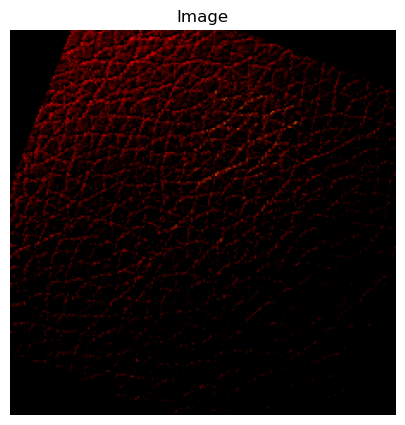

In [46]:
show_single_image_pair(val[1][0])

In [48]:
inputs.shape

torch.Size([64, 3, 224, 224])

In [49]:
labels.shape

torch.Size([64])

In [54]:
data[0].shape

torch.Size([32, 3, 224, 224])